### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! Use of generative AI is not allowed.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Data loading

In [ ]:
# Unzip train_data_2026.npy, test_data_2026.npy, val_data_2026.npy
!unzip all_data.zip

# Load the data
train_data = np.load('train_data_2026.npy')
test_data = np.load('test_data_2026.npy')
val_data = np.load('val_data_2026.npy')

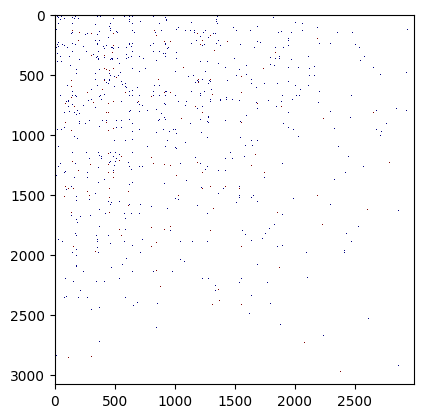

In [3]:
# Visualize the [user x user] arrays
cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
plt.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

In [ ]:
# Further visualizations to justify your answers to the familiarization questions below

**Familiarization questions**

1.	What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

2.	What are some sources of sparsity in the data?

3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?

## WebLab solutions

In [ ]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Decomposes the original sparse matrix X into two matrices W and H.
    """

    # [Your solution]

    return W, H

In [ ]:
# Solution: Min-hashing routine (for unit test on weblab)

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    # [Your solution]

    return result

## NMF-based recommender system

In [ ]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """

    # [Your solution]

    return W, H, reconstruction_error

In [ ]:
# Step 2: Fit train data

np.random.seed(5)
list_components = np.array([5,10,20,50,100])

# Compute nmf_nan() using the n_components in list_components, and following the instructions in the assignment pdf.


# Plot the final reconstruction error as a function of n_components

In [ ]:
# Step 3: Get training accuracies

# Declare some list of thresholds to try: list_thr...

for c in range(len(list_components)):

    for t in range(len(list_thr)):

        # Compute training accuracy

In [ ]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold

for c in range(len(list_components)):

    for t in range(len(list_thr)):

        # Compute validation accuracy

In [ ]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set

# Compute test accuracy

print(f"Test accuracy: {test_accuracy:g}%, thr: {thr:g}, n_components: {comp}")

## Distance-based recommender system

In [ ]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance

In [ ]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations



In [ ]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.)

In [ ]:
# Report recommendation accuracy on the independent test data